Experiments to test behaviour at differet noise power

In [52]:
import numpy as np
import pickle
from itertools import cycle, product
import dill
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow.keras.backend as K

In [53]:
from CommVAE import CommVAE1hot
from AEOshea import AEOshea1hot

In [54]:
blkSize     = 2
chDim       = 1

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim
one_hot_code = np.eye(inVecDim)

noise_pow_range = np.arange( 0.1, 3.01, 0.10 )

In [55]:
bler_data = {}
eff_snr_data = {}

Traditional QAM

QAm with unit power per dimension

In [56]:
qam1_map = np.array(list(map(list, product([-1, +1], repeat=blkSize))))
qam1_sym_pow = np.mean(np.sum(qam1_map*qam1_map,axis=1))
print( "QAM Avg. Tx Power:", qam1_sym_pow )

QAM Avg. Tx Power: 2.0


In [57]:
err = []
eff_snr = []
for n0 in noise_pow_range:
    snr_dB = 10.0 * np.log10(qam1_sym_pow/n0)
    n0_per_comp = n0 / encDim
    thisErr = 0
    thisCount = 0
    while thisErr < 500 and thisCount < int(1e6):
        txSym = np.random.randint(inVecDim, size=1000)
        txTest = qam1_map[txSym]
        rxTest = txTest + np.random.normal(scale=np.sqrt(n0_per_comp), size=txTest.shape)
        rxDecode = cdist(rxTest, qam1_map)
        rxSym = np.argmin(rxDecode,axis=1)
        thisErr += np.sum(rxSym!=txSym)
        thisCount += 1000
#     print("n0 = {:.3f}    _n0 = {:.3f}    SNR = {:6.2f}dB    err = {:4d}    tx = {:8d}".format(n0, n0_per_comp, snr_dB, thisErr, thisCount))
    err.append(thisErr/thisCount)
    eff_snr.append(snr_dB)
bler_data["QAM1"] = np.array(err)
eff_snr_data["QAM1"] = np.array(eff_snr)

High power

In [58]:
# qam2_map = 1.0/np.sqrt(encDim) * np.array(list(map(list, product([-np.sqrt(2), np.sqrt(2)], repeat=blkSize))))
# qam2_sym_pow = np.mean(np.sum(qam2_map*qam2_map,axis=1))
# print( "QAM Avg. Tx Power:", qam2_sym_pow )

In [59]:
# err = []
# eff_snr = []
# for n0 in noise_pow_range:
#     snr_dB = 10.0 * np.log10(qam2_sym_pow/n0)
#     n0_per_comp = n0 / encDim
#     thisErr = 0
#     thisCount = 0
#     while thisErr < 500 and thisCount < int(1e6):
#         txSym = np.random.randint(inVecDim, size=1000)
#         txTest = qam2_map[txSym]
#         rxTest = txTest + np.random.normal(scale=np.sqrt(n0_per_comp), size=txTest.shape)
#         rxDecode = cdist(rxTest, qam2_map)
#         rxSym = np.argmin(rxDecode,axis=1)
#         thisErr += np.sum(rxSym!=txSym)
#         thisCount += 1000
# #     print("n0 = {:.3f}    _n0 = {:.3f}    SNR = {:6.2f}dB    err = {:4d}    tx = {:8d}".format(n0, n0_per_comp, snr_dB, thisErr, thisCount))
#     err.append(thisErr/thisCount)
#     eff_snr.append(snr_dB)
# bler_data["QAM2"] = np.array(err)
# eff_snr_data["QAM2"] = np.array(eff_snr)

Even higher power

In [60]:
# qam3_map = 1.0/np.sqrt(encDim) * np.array(list(map(list, product([-np.sqrt(3), np.sqrt(3)], repeat=blkSize))))
# qam3_sym_pow = np.mean(np.sum(qam3_map*qam3_map,axis=1))
# print( "QAM Avg. Tx Power:", qam3_sym_pow )

In [61]:
# err = []
# eff_snr = []
# for n0 in noise_pow_range:
#     snr_dB = 10.0 * np.log10(qam3_sym_pow/n0)
#     n0_per_comp = n0 / encDim
#     thisErr = 0
#     thisCount = 0
#     while thisErr < 500 and thisCount < int(1e6):
#         txSym = np.random.randint(inVecDim, size=1000)
#         txTest = qam3_map[txSym]
#         rxTest = txTest + np.random.normal(scale=np.sqrt(n0_per_comp), size=txTest.shape)
#         rxDecode = cdist(rxTest, qam3_map)
#         rxSym = np.argmin(rxDecode,axis=1)
#         thisErr += np.sum(rxSym!=txSym)
#         thisCount += 1000
# #     print("n0 = {:.3f}    _n0 = {:.3f}    SNR = {:6.2f}dB    err = {:4d}    tx = {:8d}".format(n0, n0_per_comp, snr_dB, thisErr, thisCount))
#     err.append(thisErr/thisCount)
#     eff_snr.append(snr_dB)
# bler_data["QAM3"] = np.array(err)
# eff_snr_data["QAM3"] = np.array(eff_snr)

Plot the results

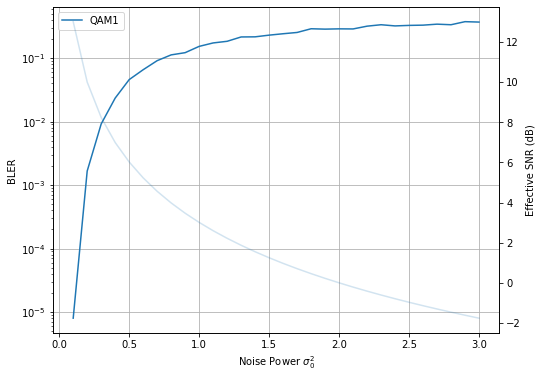

In [62]:
# fig = plt.figure(figsize=(0.80*8,0.80*6))
fig, ax_bler = plt.subplots(figsize=(8,6))
ax_snr = ax_bler.twinx()

for (label, bler) in bler_data.items():
    ax_bler.semilogy(noise_pow_range, bler, label=label)
for (label, eff_snr) in eff_snr_data.items():
    ax_snr.plot(noise_pow_range, eff_snr, label=label, alpha = 0.2)
ax_bler.set_xlabel("Noise Power $\sigma_0^2$")
ax_bler.set_ylabel("BLER")
ax_snr.set_ylabel("Effective SNR (dB)")
ax_bler.grid()
ax_bler.legend()

Load deep models and analyze

In [63]:
model_summary = {}
results = {}

if blkSize==8 and chDim==4:
    model_summary = { 
        "[1]": "./models_08x04/awgn_oshea_64_32_16_10dB_summary.dil",
        "(19)": "./models_08x04/awgn_awgn_64_32_16_n080_summary.dil",
        "(23)": "./models_08x04/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 0.10$": "./models/08x04/sigma2_010/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.10$": "./models/08x04/sigma2_010/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 0.50$": "./models/08x04/sigma2_050/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.50$": "./models/08x04/sigma2_050/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 1.50$": "./models/08x04/sigma2_150/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 1.50$": "./models/08x04/sigma2_150/awgn_rbf_64_32_16_n080_summary.dil"
    }
elif blkSize==4 and chDim==2:
    model_summary = {
        "[1]": "./models_04x02/awgn_oshea_04x02_64_32_16_10dB_summary.dil",
        "(19)": "./models_04x02/awgn_awgn_04x02_64_32_16_n040_summary.dil",
        "(23)": "./models_04x02/awgn_rbf_04x02_64_32_16_n040_summary.dil",
        
#         "(19) with $\sigma_0^2 = 0.10$": "./models/04x02/sigma2_010/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.10$": "./models/04x02/sigma2_010/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 0.50$": "./models/04x02/sigma2_050/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.50$": "./models/04x02/sigma2_050/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 1.50$": "./models/04x02/sigma2_150/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 1.50$": "./models/04x02/sigma2_150/awgn_rbf_64_32_16_n080_summary.dil",
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        "[1]": "./models_02x01/awgn_oshea_02x01_64_32_16_10dB_summary.dil",
        "(19)": "./models_02x01/awgn_awgn_02x01_64_32_16_n020_summary.dil",
        "(23)": "./models_02x01/awgn_rbf_02x01_64_32_16_n020_summary.dil",
        
#         "(19) with $\sigma_0^2 = 0.10$": "./models/02x01/sigma2_010/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.10$": "./models/02x01/sigma2_010/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 0.50$": "./models/02x01/sigma2_050/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.50$": "./models/02x01/sigma2_050/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 1.50$": "./models/02x01/sigma2_150/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 1.50$": "./models/02x01/sigma2_150/awgn_rbf_64_32_16_n080_summary.dil"
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

In [64]:
import os.path
for (model_exp, summary_file) in model_summary.items():
    log_msg = "{:40s}    {:70s}".format(model_exp,summary_file)
    if os.path.isfile(summary_file):
        log_msg += "EXISTS"
    else:
        log_msg += "NOT FOUND"
    print(log_msg)

[1]                                         ./models_02x01/awgn_oshea_02x01_64_32_16_10dB_summary.dil             EXISTS
(19)                                        ./models_02x01/awgn_awgn_02x01_64_32_16_n020_summary.dil              EXISTS
(23)                                        ./models_02x01/awgn_rbf_02x01_64_32_16_n020_summary.dil               EXISTS


In [65]:
for (model_exp,summary_file) in model_summary.items():
    summary_data = {}
    file_prefix = None
    # Load file
    results[model_exp] = {}
    with open(summary_file, "rb") as file:
        file_prefix = summary_file.split("_summary.dil")[0]
        summary_data = dill.load(file)
    for (modelid,(sym_pow,bler)) in summary_data.items():
        config_file = file_prefix + "_" + modelid + ".dil"
        config = {}
        model = None
        with open(config_file, "rb") as cfg_file:
            config = dill.load(cfg_file)
        if 'obj_fn' in config:    # obj_fn is there only for proposed CommVAE
            model = CommVAE1hot()
        else:
            model = AEOshea1hot()
        model.load_model(file_prefix+"_"+modelid)
        # Compute the Tx power and packing density
        dl_map, _ = model.encode(one_hot_code)
        dl_sym_pow = np.mean(np.sum(dl_map*dl_map,axis=1))
        unique_sym_distances = np.unique(cdist(dl_map,dl_map))
        if len(unique_sym_distances) == 1: # All distances are same and will be zero
            dl_d_min = np.inf  # This is not a valid point
            dl_en = np.nan
        else:
            dl_d_min = np.unique(cdist(dl_map,dl_map))[1]
            dl_en = dl_sym_pow / (dl_d_min**2)
        assert(np.abs(sym_pow-dl_sym_pow)<1e-3) # To make sure that we loaded right weights to model
        # save the results
        # Add this results only if this is a valid point
        if np.isfinite(dl_en):
            results[model_exp][modelid] = {}
            results[model_exp][modelid]["en"] = dl_en
            results[model_exp][modelid]["dmin"] = dl_d_min
            results[model_exp][modelid]["sym_pow"] = sym_pow
            results[model_exp][modelid]["bler"] = bler
        # Clear Session and Model
        K.clear_session()
        del model

W0719 23:03:06.996229 140018641729280 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
W0719 23:03:07.502068 140018641729280 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
W0719 23:03:07.908932 140018641729280 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
W0719 23:03:08.443666 140018641729280 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
W0719 23:03:08.888962 140018641729280 training_utils.py:1101] Output decoder missing from loss dicti

In [66]:
data = {}

for (label, result) in results.items():
    data[label] = pd.DataFrame.from_dict(result, orient='index')

Get best models for each method

In [67]:
for (model_exp,result) in data.items():
    best_model_id = result['en'].idxmin()
    summary_file = model_summary[model_exp]
    file_prefix = summary_file.split("_summary.dil")[0]
    config_file = file_prefix + "_" + best_model_id + ".dil"
    
    log_msg = "{:40s}    {:70s}".format(model_exp,config_file)
    if os.path.isfile(config_file):
        log_msg += "EXISTS"
    else:
        log_msg += "NOT FOUND"
    print(log_msg)
    
    print(result.loc[best_model_id])
    
    config = {}
    model = None
    with open(config_file, "rb") as cfg_file:
        config = dill.load(cfg_file)
    if 'obj_fn' in config:    # obj_fn is there only for proposed CommVAE
        model = CommVAE1hot()
    else:
        model = AEOshea1hot()
    model.load_model(file_prefix+"_"+best_model_id)
    
    # Do MC for BLER
    err = []
    eff_snr = []
    for n0 in noise_pow_range:
        snr_dB = 10.0 * np.log10(result.loc[best_model_id]["sym_pow"]/n0)
        n0_per_comp = n0 / encDim
        thisErr = 0
        thisCount = 0
        while thisErr < 500 and thisCount < int(1e6):
            txSym = np.random.randint(inVecDim, size=1000)
            tx1hot = np.eye(inVecDim)[txSym]
            txTest, _ = model.encode(tx1hot)
            rxTest = txTest + np.random.normal(scale=np.sqrt(n0_per_comp), size=txTest.shape)
            rxDecode = model.decode(rxTest)
            rxSym = np.argmax(rxDecode,axis=1)
            thisErr += np.sum(rxSym!=txSym)
            thisCount += 1000
#         print("n0 = {:.3f}    _n0 = {:.3f}    SNR = {:6.2f}dB    err = {:4d}    tx = {:8d}".format(n0, n0_per_comp, snr_dB, thisErr, thisCount))
        err.append(thisErr/thisCount)
        eff_snr.append(snr_dB)
    key_string = "{} ($pow={:.3f}$, $E_n={:.3f}$)".format(model_exp,result.loc[best_model_id,"sym_pow"],result.loc[best_model_id,"en"])
    bler_data[key_string] = np.array(err)
    eff_snr_data[key_string] = np.array(eff_snr)
    
    # Clear Session and Model
    K.clear_session()
    
    del model

[1]                                         ./models_02x01/awgn_oshea_02x01_64_32_16_10dB_20190312075639.dil      EXISTS
en                                                  0.504765
dmin                                                 1.99769
sym_pow                                              2.01439
bler       [0.297, 0.256, 0.20066666666666666, 0.15475, 0...
Name: 20190312075639, dtype: object


W0719 23:05:12.587196 140018641729280 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


(19)                                        ./models_02x01/awgn_awgn_02x01_64_32_16_n020_20190312103121.dil       EXISTS
en                                                  0.501052
dmin                                                 1.17344
sym_pow                                             0.689927
bler       [0.2885, 0.23266666666666666, 0.19333333333333...
Name: 20190312103121, dtype: object


W0719 23:05:29.989587 140018641729280 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


(23)                                        ./models_02x01/awgn_rbf_02x01_64_32_16_n020_20190312104906.dil        EXISTS
en                                                  0.505949
dmin                                                 1.84918
sym_pow                                              1.73007
bler       [0.288, 0.241, 0.19733333333333333, 0.1535, 0....
Name: 20190312104906, dtype: object


W0719 23:05:31.618276 140018641729280 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


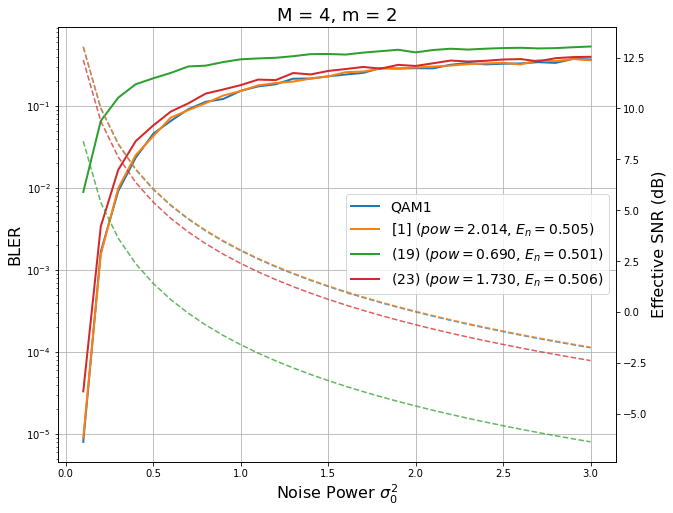

In [68]:
fig, ax_bler = plt.subplots(figsize=(10,8))
ax_snr = ax_bler.twinx()

for (label, bler) in bler_data.items():
    ax_bler.semilogy(noise_pow_range, bler, label=label, linewidth=2.0)
for (label, eff_snr) in eff_snr_data.items():
    ax_snr.plot(noise_pow_range, eff_snr, label=label, linestyle="--", alpha = 0.75)
ax_bler.semilogy    

plt.title("M = {}, m = {}".format(2**blkSize,2*chDim), fontdict={'fontsize':18})
ax_bler.set_xlabel("Noise Power $\sigma_0^2$", fontdict={'fontsize':16})
ax_bler.set_ylabel("BLER", fontdict={'fontsize':16})
ax_snr.set_ylabel("Effective SNR (dB)", fontdict={'fontsize':16})
ax_bler.grid()
ax_bler.legend(loc="right", prop={'size':14})
plt.savefig("awgn_n0_{:02d}x{:02d}.png".format(blkSize,chDim), format='png', bbox_inches='tight')